In [ ]:
#------------------------------------------------------------------------------#
# Title:        Group Project - Music Genre Classification                     #
# Course:       COMP9444 Neural Networks 2022 Term Three                       #
# Mentor:       Arun Kumar Marndi                                              #
# Session:      Thursday 16:00 - 18:00                                         #
#                                                                              #
# Team:         NNKing                                                         #
# Author/s:     Peter Huang (z5313504)                                         #
#               Fiona O’Chee (z5122503)                                        #
#               Evan Karl Lam (z5333206)                                       #
#               Theo Graftieaux (z5258743)                                     #
#               Oliver Guo (z5191682)                                          #
#                                                                              #
#------------------------------------------------------------------------------#

# Overview

TODO

### Usage Guide

No execution required; all results are already displayed for convenience. 





# Initial Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/COMP9444
!ls  # Confirm project in root directory

[Errno 2] No such file or directory: 'drive/MyDrive/COMP9444'
/content/drive/.shortcut-targets-by-id/1f2FfExUGYN2E54Q1zrEAFNotNfq9wlni/COMP9444
archived_obsolete  input  main.ipynb  output  peter  README.md


In [ ]:
import time
import os
import warnings
import IPython.display as ipd
import tqdm.notebook
import ast
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import keras
from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import glob
import h5py

import sklearn as skl
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

In [ ]:
%matplotlib inline

In [ ]:
# Helper function. Conveniently loads raw data into dataframes.
# (adapted from source: https://github.com/mdeff/fma)
def load(filepath):
    filename = os.path.basename(filepath)

    if 'features' in filename:
        # Use rows 0, 1 and 2 to comprise feature headings
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        columns = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for c in columns:
            tracks[c] = tracks[c].map(ast.literal_eval)

        columns = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for c in columns:
            tracks[c] = pd.to_datetime(tracks[c])

        subsets = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    'category', categories=subsets, ordered=True)
        except (ValueError, TypeError):
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=subsets, ordered=True))

        columns = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for c in columns:
            tracks[c] = tracks[c].astype('category')

        return tracks

In [ ]:
# Load data from 3 FMA files which comprise the raw dataset.
input_path = 'input/fma_metadata'
tracks = load(f'{input_path}/tracks.csv')
features = load(f'{input_path}/features.csv')
echonest = load(f'{input_path}/echonest.csv')

# path for all the audio data
root_path = 'input/fma_small'

# Check matching dimension
np.testing.assert_array_equal(features.index, tracks.index) 
assert echonest.index.isin(tracks.index).all()

In [ ]:
features.index, tracks.index

(Int64Index([     2,      3,      5,     10,     20,     26,     30,     46,
                 48,    134,
             ...
             155310, 155311, 155312, 155314, 155315, 155316, 155317, 155318,
             155319, 155320],
            dtype='int64', name='track_id', length=106574),
 Int64Index([     2,      3,      5,     10,     20,     26,     30,     46,
                 48,    134,
             ...
             155310, 155311, 155312, 155314, 155315, 155316, 155317, 155318,
             155319, 155320],
            dtype='int64', name='track_id', length=106574))

# Exploratory Data Analysis

The raw dataset is provided by FMA and is composed from 3 separate files:

* tracks.csv
* features.csv
* echonest.csv

Source: fma_metadata.zip from https://github.com/mdeff/fma

### Basic

This sub-section aims to gain a general understanding of the raw data.

##### Tracks Dataset

In [ ]:
# Split tracks.csv into training, validation, testing sets.

# Note: While this is considered preprocessing (as opposed to exploration) it is 
# intentionally done here to guard against Data Snooping Bias. By hiding validation 
# and test sets and only exploring training data, we aim to avoid stumbling upon 
# interesting test set patterns which could bias optimistic generalization error estimates.

df_tracks_filtered = tracks[[
    ('set', 'split'), 
    ('set', 'subset'),
    ('track', 'genre_top'),
]]
df_tracks_filtered = df_tracks_filtered[df_tracks_filtered[('set', 'subset')] == 'small']
df_tracks_train = df_tracks_filtered[df_tracks_filtered[('set', 'split')] == 'training']
df_tracks_validation = df_tracks_filtered[df_tracks_filtered[('set', 'split')] == 'validation']
df_tracks_testing = df_tracks_filtered[df_tracks_filtered[('set', 'split')] == 'test']

df_tracks_train, df_tracks_validation, df_tracks_testing

(               set            track
              split subset genre_top
 track_id                           
 2         training  small   Hip-Hop
 5         training  small   Hip-Hop
 10        training  small       Pop
 140       training  small      Folk
 141       training  small      Folk
 ...            ...    ...       ...
 153955    training  small       Pop
 153956    training  small       Pop
 154413    training  small       Pop
 154414    training  small       Pop
 155066    training  small   Hip-Hop
 
 [6400 rows x 3 columns],                  set                 track
                split subset      genre_top
 track_id                                  
 148       validation  small   Experimental
 459       validation  small           Rock
 602       validation  small           Folk
 690       validation  small           Rock
 993       validation  small           Rock
 ...              ...    ...            ...
 148234    validation  small           Folk
 148235    vali

In [ ]:
# Shows that FMA features in tracks.csv are organised in a top and sub property 
# hierarchy, arranged as tuples.
# e.g album has "sub-features" comments, date_created, ..., tags, etc
tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Data columns (total 52 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   (album, comments)            106574 non-null  int64         
 1   (album, date_created)        103045 non-null  datetime64[ns]
 2   (album, date_released)       70294 non-null   datetime64[ns]
 3   (album, engineer)            15295 non-null   object        
 4   (album, favorites)           106574 non-null  int64         
 5   (album, id)                  106574 non-null  int64         
 6   (album, information)         83149 non-null   category      
 7   (album, listens)             106574 non-null  int64         
 8   (album, producer)            18060 non-null   object        
 9   (album, tags)                106574 non-null  object        
 10  (album, title)               105549 non-null  object        
 11  (album, tracks)           

In [ ]:
tracks.describe()

album                                              \
            comments      favorites             id       listens   
count  106574.000000  106574.000000  106574.000000  1.065740e+05   
mean        0.394946       1.286927   12826.933914  3.212031e+04   
std         2.268915       3.133035    6290.261805  1.478532e+05   
min        -1.000000      -1.000000      -1.000000 -1.000000e+00   
25%         0.000000       0.000000    7793.000000  3.361000e+03   
50%         0.000000       0.000000   13374.000000  8.982000e+03   
75%         0.000000       1.000000   18203.000000  2.363500e+04   
max        53.000000      61.000000   22940.000000  3.564243e+06   

                             artist                                \
              tracks       comments      favorites             id   
count  106574.000000  106574.000000  106574.000000  106574.000000   
mean       19.721452       1.894702      30.041915   12036.770404   
std        39.943673       6.297679     100.511408    6881.420867   
min        -1.000000      -1.000000      -1.000000       1.000000   
25%         7.000000       0.000000       1.000000    6443.000000   
50%        11.000000       0.000000       5.000000   12029.500000   
75%        17.000000       1.000000      16.000000   18011.000000   
max       652.000000      79.000000     963.000000   24357.000000   

                                           track                 \
           latitude     longitude       bit_rate       comments   
count  44544.000000  44544.000000  106574.000000  106574.000000   
mean      39.901626    -38.668642  263274.695048       0.031621   
std       18.240860     65.237220   67623.443584       0.321993   
min      -45.878760   -157.526855      -1.000000       0.000000   
25%       39.271398    -79.997459  192000.000000       0.000000   
50%       41.387917    -73.554431  299914.000000       0.000000   
75%       48.856930      4.351710  320000.000000       0.000000   
max       67.286005    175.277000  448000.000000      37.000000   

                                                                  \
            duration      favorites      interest        listens   
count  106574.000000  106574.000000  1.065740e+05  106574.000000   
mean      277.849100       3.182521  3.541310e+03    2329.353548   
std       305.518553      13.513820  1.901743e+04    8028.070647   
min         0.000000       0.000000  2.000000e+00       0.000000   
25%       149.000000       0.000000  5.990000e+02     292.000000   
50%       216.000000       1.000000  1.314000e+03     764.000000   
75%       305.000000       3.000000  3.059000e+03    2018.000000   
max     18350.000000    1482.000000  3.293557e+06  543252.000000   

                      
              number  
count  106574.000000  
mean        8.260945  
std        15.243271  
min         0.000000  
25%         2.000000  
50%         5.000000  
75%         9.000000  
max       255.000000

In [ ]:
# 8000 tracks, 52 properties
tracks.shape

(106574, 52)

In [ ]:
# Show general structure, values and data types of properties for each track.
tracks.head()

# Interpretation: tracks.csv contains metadata on each track. Some attributes 
# could serve as features (e.g tags, artist), but these will not be used for 
# training as the project goal is to classify based on the music itself. 

# Only 'genre_top' (which is applicable for our FMA dataset size choice) will 
# be used via a later track_id join with features.csv, serving as our target 
# output variable y.

album                                                          \
         comments        date_created date_released engineer favorites id   
track_id                                                                    
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
3               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4  6   
20              0 2008-11-26 01:45:05    2009-01-06      NaN         2  4   

                                                                           \
                                        information listens producer tags   
track_id                                                                    
2                                           <p></p>    6073      NaN   []   
3                                           <p></p>    6073      NaN   []   
5                                           <p></p>    6073      NaN   []   
10                                              NaN   47632      NaN   []   
20        <p> "spiritual songs" from Nicky Cook</p>    2710      NaN   []   

          ...       track                         \
          ... information interest language_code   
track_id  ...                                      
2         ...         NaN     4656            en   
3         ...         NaN     1470            en   
5         ...         NaN     1933            en   
10        ...         NaN    54881            en   
20        ...         NaN      978            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...     514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...     361      NaN   

                                                 
         number publisher tags            title  
track_id                                         
2             3       NaN   []             Food  
3             4       NaN   []     Electric Ave  
5             6       NaN   []       This World  
10            1       NaN   []          Freeway  
20            3       NaN   []  Spiritual Level  

[5 rows x 52 columns]

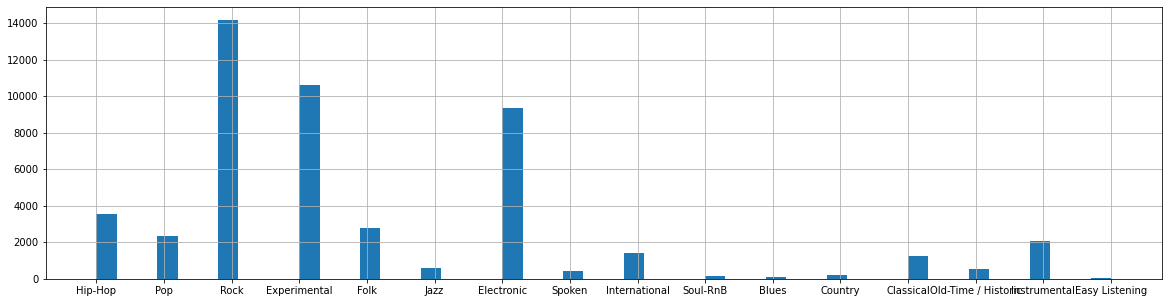

In [ ]:
# Display top level genres. While it shows the base raw data classes are unbalanced 
# the analysis will be based on 8 balanaced classes (because only track_ids applicable 
# to the 7.7 GB fma_small dataset are filtered for in pre-processing)

tracks['track']['genre_top'].hist(bins=50, figsize=(20, 5))

##### Features Dataset

This section explores features.csv.

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Columns: 518 entries, ('chroma_cens', 'kurtosis', '01') to ('zcr', 'std', '01')
dtypes: float64(518)
memory usage: 422.0 MB


In [ ]:
features.describe()

feature       chroma_cens                                               \
statistics       kurtosis                                                
number                 01             02             03             04   
count       106574.000000  106574.000000  106574.000000  106574.000000   
mean             0.439999       0.199756       0.334683       0.270263   
std             32.285524      11.120903       9.980692      19.074557   
min             -1.955806      -1.936607      -1.967450      -3.000000   
25%             -0.636597      -0.665684      -0.629114      -0.644747   
50%             -0.176557      -0.221131      -0.152708      -0.191032   
75%              0.485000       0.410097       0.529836       0.446800   
max           8843.367188    2864.075195    1777.615967    4257.045898   

feature                                                                 \
statistics                                                               
number                 05             06             07             08   
count       106574.000000  106574.000000  106574.000000  106574.000000   
mean             0.294806       0.315635       0.273511       0.334927   
std             15.025603      12.176182      16.975991      15.486402   
min             -1.921206      -1.923740      -1.935382      -3.000000   
25%             -0.656779      -0.622579      -0.646798      -0.635741   
50%             -0.198025      -0.152089      -0.187959      -0.161478   
75%              0.452680       0.513112       0.472161       0.525814   
max           3188.034424    2809.779297    4281.090820    3869.482178   

feature                                   ...        tonnetz                 \
statistics                                ...            std                  
number                 09             10  ...             04             05   
count       106574.000000  106574.000000  ...  106574.000000  106574.000000   
mean             0.201939       0.285631  ...       0.098667       0.021569   
std              7.364308       8.175257  ...       0.037101       0.006076   
min             -3.000000      -3.000000  ...       0.005681       0.000087   
25%             -0.667799      -0.660292  ...       0.071240       0.017226   
50%             -0.214547      -0.181836  ...       0.093500       0.020636   
75%              0.432480       0.495568  ...       0.121007       0.024990   
max           1217.209473    1772.918213  ...       0.332470       0.092869   

feature                              zcr                                \
statistics                      kurtosis            max           mean   
number                 06             01             01             01   
count       106574.000000  106574.000000  106574.000000  106574.000000   
mean             0.021880      29.464638       0.381368       0.052755   
std              0.006125      88.975395       0.183414       0.032634   
min              0.000368      -1.967539       0.010254       0.000055   
25%              0.017542       3.316640       0.246582       0.032913   
50%              0.020964       9.714652       0.357910       0.047077   
75%              0.025252      26.981386       0.471680       0.064616   
max              0.116128    8438.014648       0.999512       0.878024   

feature                                                                 
statistics         median            min           skew            std  
number                 01             01             01             01  
count       106574.000000  106574.000000  106574.000000  106574.000000  
mean             0.043576       0.002342       3.214247       0.040303  
std              0.031703       0.005152       3.045345       0.027259  
min              0.000000       0.000000     -15.727972       0.000436  
25%              0.024902       0.000000       1.400700       0.022054  
50%              0.037598       0.000000       2.404834       0.033566  
75%              0.054199   

In [ ]:
# Display top level features
features.columns.levels[0]

Index(['chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 'rmse',
       'spectral_bandwidth', 'spectral_centroid', 'spectral_contrast',
       'spectral_rolloff', 'tonnetz', 'zcr'],
      dtype='object', name='feature')

In [ ]:
# Shows each audio feature is sub-featured in terms of a statistical measure, such as kurtosis and skew.
list(features.columns)

[('chroma_cens', 'kurtosis', '01'),
 ('chroma_cens', 'kurtosis', '02'),
 ('chroma_cens', 'kurtosis', '03'),
 ('chroma_cens', 'kurtosis', '04'),
 ('chroma_cens', 'kurtosis', '05'),
 ('chroma_cens', 'kurtosis', '06'),
 ('chroma_cens', 'kurtosis', '07'),
 ('chroma_cens', 'kurtosis', '08'),
 ('chroma_cens', 'kurtosis', '09'),
 ('chroma_cens', 'kurtosis', '10'),
 ('chroma_cens', 'kurtosis', '11'),
 ('chroma_cens', 'kurtosis', '12'),
 ('chroma_cens', 'max', '01'),
 ('chroma_cens', 'max', '02'),
 ('chroma_cens', 'max', '03'),
 ('chroma_cens', 'max', '04'),
 ('chroma_cens', 'max', '05'),
 ('chroma_cens', 'max', '06'),
 ('chroma_cens', 'max', '07'),
 ('chroma_cens', 'max', '08'),
 ('chroma_cens', 'max', '09'),
 ('chroma_cens', 'max', '10'),
 ('chroma_cens', 'max', '11'),
 ('chroma_cens', 'max', '12'),
 ('chroma_cens', 'mean', '01'),
 ('chroma_cens', 'mean', '02'),
 ('chroma_cens', 'mean', '03'),
 ('chroma_cens', 'mean', '04'),
 ('chroma_cens', 'mean', '05'),
 ('chroma_cens', 'mean', '06'),
 ('c

In [ ]:
features.shape

(106574, 518)

In [ ]:
features.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
3           1.366848  1.054094  0.108103  0.619185  ...  0.063831  0.014212   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
20         -0.289294 -0.816410  0.043851 -0.804761  ...  0.095003  0.022492   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.000000   
3           0.017740   2.824694  0.466309  0.084578  0.063965  0.000000   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.000000   
20          0.021355  16.669037  0.469727  0.047225  0.040039  0.000977   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
3           1.716724  0.069330  
5           2.193303  0.044861  
10          3.542325  0.040800  
20          3.189831  0.030993  

[5 rows x 518 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf2da4ef90>,
      dtype=object)

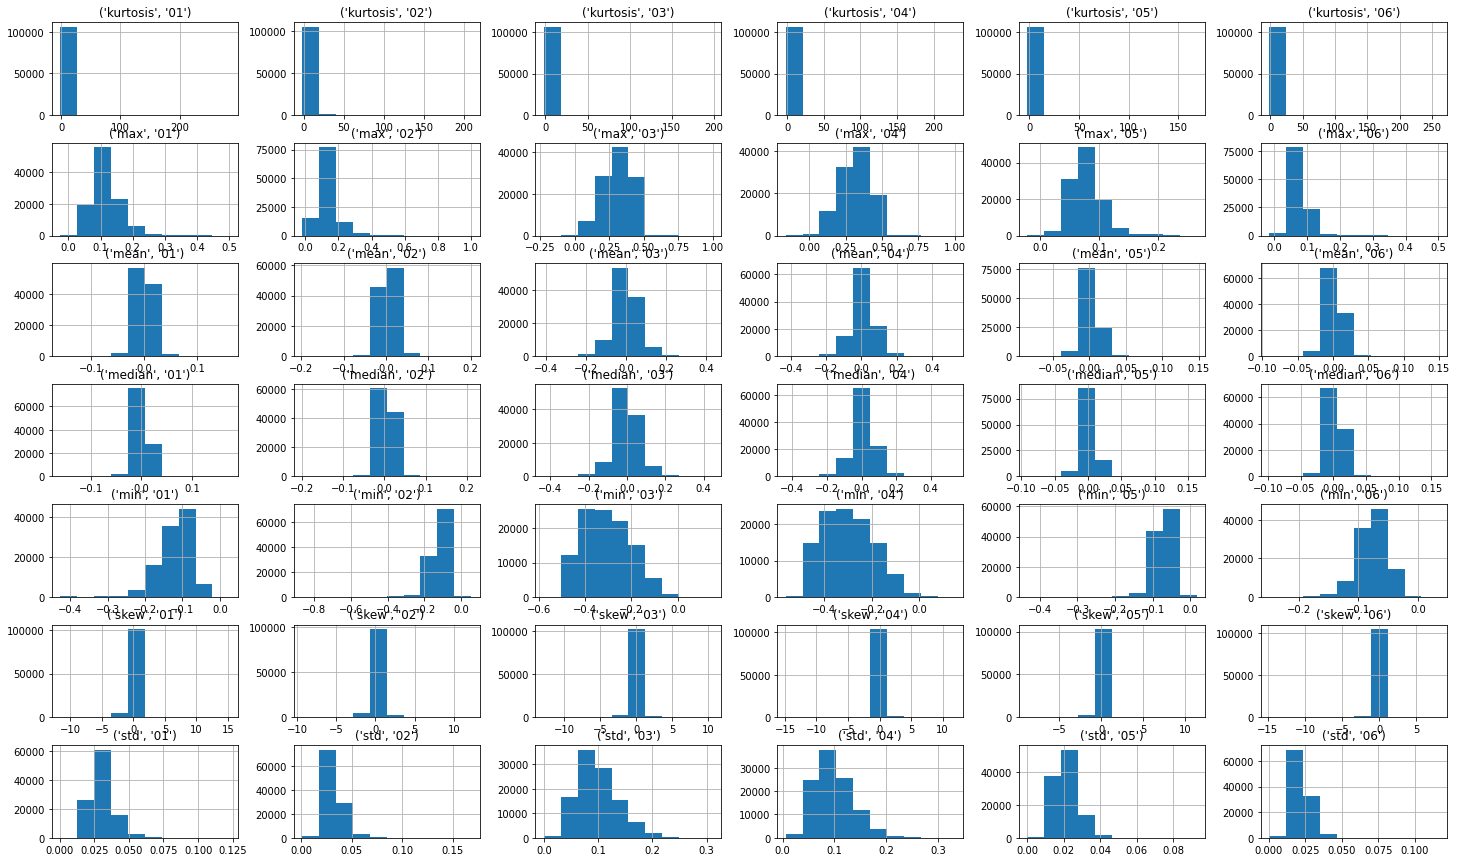

In [ ]:
# features['tonnetz']['kurtosis'].hist(bins=50, figsize=(20,15))
features['tonnetz'].hist( figsize=(25,15))

In [ ]:
# attributes = ["median_house_ value", "median_income", "total_rooms", "housing_median_age"]
# scatter_matrix(features[attributes], figsize=(12, 8))

##### EchoNest Dataset

In [ ]:
echonest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13129 entries, 2 to 124911
Columns: 249 entries, ('echonest', 'audio_features', 'acousticness') to ('echonest', 'temporal_features', '223')
dtypes: float64(244), object(5)
memory usage: 25.0+ MB


In [ ]:
echonest.columns.levels[1]

Index(['audio_features', 'metadata', 'ranks', 'social_features',
       'temporal_features'],
      dtype='object')

In [ ]:
list(echonest.columns)[:30]

[('echonest', 'audio_features', 'acousticness'),
 ('echonest', 'audio_features', 'danceability'),
 ('echonest', 'audio_features', 'energy'),
 ('echonest', 'audio_features', 'instrumentalness'),
 ('echonest', 'audio_features', 'liveness'),
 ('echonest', 'audio_features', 'speechiness'),
 ('echonest', 'audio_features', 'tempo'),
 ('echonest', 'audio_features', 'valence'),
 ('echonest', 'metadata', 'album_date'),
 ('echonest', 'metadata', 'album_name'),
 ('echonest', 'metadata', 'artist_latitude'),
 ('echonest', 'metadata', 'artist_location'),
 ('echonest', 'metadata', 'artist_longitude'),
 ('echonest', 'metadata', 'artist_name'),
 ('echonest', 'metadata', 'release'),
 ('echonest', 'ranks', 'artist_discovery_rank'),
 ('echonest', 'ranks', 'artist_familiarity_rank'),
 ('echonest', 'ranks', 'artist_hotttnesss_rank'),
 ('echonest', 'ranks', 'song_currency_rank'),
 ('echonest', 'ranks', 'song_hotttnesss_rank'),
 ('echonest', 'social_features', 'artist_discovery'),
 ('echonest', 'social_featur

In [ ]:
echonest.shape

(13129, 249)

In [ ]:
echonest.head()

echonest                                                    \
         audio_features                                                     
           acousticness danceability    energy instrumentalness  liveness   
track_id                                                                    
2              0.416675     0.675894  0.634476         0.010628  0.177647   
3              0.374408     0.528643  0.817461         0.001851  0.105880   
5              0.043567     0.745566  0.701470         0.000697  0.373143   
10             0.951670     0.658179  0.924525         0.965427  0.115474   
134            0.452217     0.513238  0.560410         0.019443  0.096567   

                                                                        ...  \
                                           metadata                     ...   
         speechiness    tempo   valence  album_date         album_name  ...   
track_id                                                                ...   
2           0.159310  165.922  0.576661         NaN                NaN  ...   
3           0.461818  126.957  0.269240         NaN                NaN  ...   
5           0.124595  100.260  0.621661         NaN                NaN  ...   
10          0.032985  111.562  0.963590  2008-03-11  Constant Hitmaker  ...   
134         0.525519  114.290  0.894072         NaN                NaN  ...   

                                                                              \
         temporal_features                                                     
                       214        215       216       217       218      219   
track_id                                                                       
2                -1.992303   6.805694  0.233070  0.192880  0.027455  0.06408   
3                -1.582331   8.889308  0.258464  0.220905  0.081368  0.06413   
5                -2.288358  11.527109  0.256821  0.237820  0.060122  0.06014   
10               -3.662988  21.508228  0.283352  0.267070  0.125704  0.08082   
134              -1.452696   2.356398  0.234686  0.199550  0.149332  0.06440   

                                                     
                                                     
               220       221        222         223  
track_id                                             
2          3.67696   3.61288  13.316690  262.929749  
3          6.08277   6.01864  16.673548  325.581085  
5          5.92649   5.86635  16.013849  356.755737  
10         8.41401   8.33319  21.317064  483.403809  
134       11.26707  11.20267  26.454180  751.147705  

[5 rows x 249 columns]

In [ ]:
echonest.describe()

echonest                                               \
      audio_features                                                
        acousticness  danceability        energy instrumentalness   
count   1.312900e+04  13129.000000  13129.000000     13129.000000   
mean    5.246876e-01      0.487290      0.537516         0.640536   
std     3.837186e-01      0.190148      0.278049         0.361430   
min     9.035000e-07      0.051307      0.000020         0.000000   
25%     1.037726e-01      0.344759      0.321300         0.323466   
50%     5.739848e-01      0.485635      0.549113         0.838134   
75%     9.207270e-01      0.629094      0.776254         0.918244   
max     9.957965e-01      0.968645      0.999964         0.998016   

                                                                               \
                                                                     metadata   
           liveness   speechiness         tempo       valence artist_latitude   
count  13129.000000  13129.000000  13129.000000  13129.000000     9770.000000   
mean       0.187804      0.099174    123.080061      0.439761       39.961892   
std        0.158051      0.137381     35.015137      0.276028       15.554275   
min        0.025297      0.022324     12.753000      0.000010      -45.867100   
25%        0.101406      0.036932     95.967000      0.197321       37.784827   
50%        0.119002      0.049019    120.057000      0.417743       40.781400   
75%        0.211041      0.085452    145.318000      0.665575       47.254575   
max        0.980330      0.966177    251.072000      0.999990       68.927500   

                        ...                                                \
                        ... temporal_features                               
      artist_longitude  ...               214           215           216   
count      9770.000000  ...      13129.000000  13129.000000  13129.000000   
mean        -49.984040  ...         -1.966002     10.745951      0.308984   
std          59.377974  ...          1.708499     20.053146      0.140164   
min        -155.434000  ...        -17.966162     -1.867880      0.129023   
25%         -87.632400  ...         -2.587326      1.229409      0.242371   
50%         -74.007100  ...         -1.565120      4.355214      0.286014   
75%          -0.127140  ...         -0.875471     11.407599      0.339086   
max         174.770000  ...          1.663782    423.621094      5.211423   

                                                                             \
                                                                              
                217           218           219           220           221   
count  13129.000000  13129.000000  13129.000000  13129.000000  13129.000000   
mean       0.255381      0.163876      0.068526      4.183428      4.114902   
std        0.083731      3.484144      0.010930      4.967481      4.967004   
min        0.098280      0.000518      0.060000      0.322180      0.224580   
25%        0.208750      0.021321      0.063080      1.817050      1.749660   
50%        0.242745      0.042146      0.064490      3.094060      3.026260   
75%        0.285305      0.087516      0.070070      5.147530      5.079770   
max        1.680570    375.744781      0.342000    226.326767    226.244080   

                                   
                                   
                222           223  
count  13129.000000  13129.000000  
mean       7.605432    138.932366  
std        6.444884    225.584951  
min       -3.566834     -1.687834  
25%        2.866906     15.565598  
50%        5.502340     55.874954  
75%       10.597994    175.938553  
max       67.041878   4790.696777  

[8 rows x 244 columns]

In [ ]:
tracks['set']

split  subset
track_id                    
2           training   small
3           training  medium
5           training   small
10          training   small
20          training   large
...              ...     ...
155316      training   large
155317      training   large
155318      training   large
155319      training   large
155320    validation   large

[106574 rows x 2 columns]

In [ ]:
df_truncated.shape

(8000, 4)

In [ ]:
df_truncated[('track', 'genre_top')].value_counts()

Electronic             1000
Experimental           1000
Folk                   1000
Hip-Hop                1000
Instrumental           1000
International          1000
Pop                    1000
Rock                   1000
Blues                     0
Classical                 0
Country                   0
Easy Listening            0
Jazz                      0
Old-Time / Historic       0
Soul-RnB                  0
Spoken                    0
Name: (track, genre_top), dtype: int64

In [ ]:
df_truncated[('set', 'split')].value_counts()

training      6400
validation     800
test           800
Name: (set, split), dtype: int64

In [ ]:
mfcc = features['mfcc']
mfcc.head()

statistics   kurtosis                                                    \
number             01        02        03        04        05        06   
track_id                                                                  
2            3.856789  1.541901  0.000816  0.330728  0.118731 -0.342687   
3            4.296755  1.399977  0.112535 -0.211170  0.032953 -0.023489   
5            2.624517  2.415293  0.440233 -0.782131 -0.771069 -0.724216   
10           5.076893  1.161854  2.095651  1.372743 -0.203574 -0.345354   
20          11.880132  4.085320  0.002655  1.518562  0.181947  0.339014   

statistics                                          ...        std             \
number            07        08        09        10  ...         11         12   
track_id                                            ...                         
2          -0.259252  0.146735  0.410656 -0.162872  ...  10.059609   8.601942   
3           0.150404  0.046454  0.033484 -0.064596  ...   8.771966  10.026867   
5           0.090260  0.152119  0.261731 -0.608905  ...   8.863638   9.581952   
10         -0.529139  0.561974  0.281350 -0.150672  ...   8.289734   7.985110   
20          0.367611  0.069932 -0.016032  0.026012  ...   7.706648   6.498904   

statistics                                                              \
number            13        14        15        16        17        18   
track_id                                                                 
2           9.284250  9.245516  8.520863  8.560472  7.651871  7.246555   
3           6.978541  7.650417  9.600357  7.222888  8.398293  7.285423   
5           8.895723  8.141456  8.201844  7.780963  7.132692  7.539753   
10          7.075400  6.972649  7.071393  7.270959  7.051070  6.928591   
20          6.845514  6.934421  7.019398  6.983841  6.813648  7.520811   

statistics                      
number            19        20  
track_id                        
2           7.077188  7.391859  
3           7.417791  8.777440  
5           8.452527  7.334442  
10          6.430473  6.186294  
20          7.098001  7.032246  

[5 rows x 140 columns]

In [ ]:
mfcc.shape

(106574, 140)

In [ ]:
small = tracks['set', 'subset'] <= 'small'
genre_Instrumental = tracks['track', 'genre_top'] == 'Instrumental'
genre2_HH = tracks['track', 'genre_top'] == 'Hip-Hop'

print(small.shape, genre_Instrumental.shape, genre2_HH.shape)

X = features.loc[small & (genre_Instrumental | genre2_HH), 'mfcc']
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

y = tracks.loc[small & (genre_Instrumental | genre2_HH), ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
plt.show()
X.shape, y.shape

(106574,) (106574,) (106574,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


NameError: ignored

In [ ]:
subset = tracks.index[tracks['set', 'subset'] <= 'small']


assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()

features_all = features.join(echonest, how='inner').sort_index(axis=1)
print('Not enough Echonest features: {}'.format(features_all.shape))

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

### Univariate Analysis

In [ ]:
# TODO

### Bivariate Analysis

In [ ]:
# features_corr_matrix = features.corr()
# features_corr_matrix['tonnetz'].sort_values(ascending=False)

#### Pairwise Correlations

In [ ]:
# TODO

# Data Preprocessing

### General

TODO mention something about Missing Value Imputation and Outlier analysis already pre-cleaned here later

In [ ]:
# Use random seed for repeat execution reproducibility 
RANDOM_SEED = 42

In [ ]:
train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

print('Split: {} training, {} validation, {} testing'.format(*map(len, [train, val, test])))

In [ ]:
genres = list(LabelEncoder().fit(tracks['track', 'genre_top']).classes_)
# genres = list(tracks['track', 'genre_top'].unique())
print('Top genres ({}): {}'.format(len(genres), genres))

In [ ]:
genres = list(MultiLabelBinarizer().fit(tracks['track', 'genres_all']).classes_)
print('All genres ({}): {}'.format(len(genres), genres))

In [ ]:
def pre_process(tracks, features, columns, multi_label=False, verbose=False):
    if not multi_label:
        # Assign an integer value to each genre.
        enc = LabelEncoder()
        labels = tracks['track', 'genre_top']
        #y = enc.fit_transform(tracks['track', 'genre_top'])
    else:
        # Create an indicator matrix.
        enc = MultiLabelBinarizer()
        labels = tracks['track', 'genres_all']
        #labels = tracks['track', 'genres']

    # Split in training, validation and testing sets.
    y_train = enc.fit_transform(labels[train])
    y_val = enc.transform(labels[val])
    y_test = enc.transform(labels[test])
    X_train = features.loc[train, columns].values
    X_val = features.loc[val, columns].values
    X_test = features.loc[test, columns].values
    X_train, y_train = shuffle(X_train, y_train, random_state=42)
    
    # Standardize features, removing the mean and scaling to unit variance.
    scaler = StandardScaler(copy=False)
    scaler.fit_transform(X_train)
    scaler.transform(X_val)
    scaler.transform(X_test)
    
    return y_train, y_val, y_test, X_train, X_val, X_test

In [ ]:
def test_classifiers_features(classifiers, feature_sets, multi_label=False):
    columns = list(classifiers.keys()).insert(0, 'dim')
    scores = pd.DataFrame(columns=columns, index=feature_sets.keys())
    # f1_scores = pd.DataFrame(columns=columns, index=feature_sets.keys())
    for fset_name, fset in tqdm.notebook.tqdm(feature_sets.items(), desc='features'):
        y_train, y_val, y_test, X_train, X_val, X_test = pre_process(tracks, features_all, fset, multi_label)
        scores.loc[fset_name, 'dim'] = X_train.shape[1]
        for clf_name, clf in classifiers.items():  # tqdm_notebook(classifiers.items(), desc='classifiers', leave=False):
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
            scores.loc[fset_name, clf_name] = score
            y_pred = clf.predict(X_test)
            # f1 = f1_score(y_test, y_pred, average="macro")
            # f1_scores.loc[fset_name, clf_name] = f1
    return scores#, f1_scores

In [ ]:
# Helper function, highlights the top performance scoring model for each feature subset
def format_scores(scores):
    def highlight(s):
        is_max = s == max(s[1:])
        return ['background-color: green' if v else '' for v in is_max]
    scores = scores.style.apply(highlight, axis=1)
    return scores.format('{:.2%}', subset = pd.IndexSlice[:, scores.columns[1]:])

#### Spectrograms (For CRNN Model)

In [ ]:
def get_audio_path(audio_dir, track_id):
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

"""
Get track IDs from the mp3s in a directory.
"""
def get_trackIDs_from_dir(audio_dir):
    tids = []
    for _, dirnames, files in os.walk(audio_dir):
        if dirnames == []:
            tids.extend(int(file[:-4]) for file in files)
    return tids

In [ ]:
AUDIO_DIR = 'input/fma_small'
tids = get_trackIDs_from_dir(AUDIO_DIR)
len(tids)  # should return 8 * 1000 = 8000, 1000 songs per genre

8000

In [ ]:
keep_cols = [
    ('set', 'split'),
    ('set', 'subset'),
    ('track', 'genre_top')
]

filepath = 'input/fma_metadata/tracks.csv'
tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])
df_all = tracks[keep_cols]
df_all = df_all[df_all[('set', 'subset')] == 'small']

df_all['track_id'] = df_all.index
df_all.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


set            track track_id
             split subset genre_top         
track_id                                    
2         training  small   Hip-Hop        2
5         training  small   Hip-Hop        5
10        training  small       Pop       10
140       training  small      Folk      140
141       training  small      Folk      141

In [ ]:
grouped_df = df_all.groupby(('track', 'genre_top')).first().reset_index()
grouped_df.head(15)

track         set        track_id
       genre_top       split subset         
0     Electronic    training  small     1482
1   Experimental  validation  small      148
2           Folk    training  small      140
3        Hip-Hop    training  small        2
4   Instrumental        test  small    10250
5  International    training  small      666
6            Pop    training  small       10
7           Rock        test  small      182

In [ ]:
def plot_spectogram(track_id, genre):
    filename = get_audio_path(AUDIO_DIR, track_id)
    y, sr = librosa.load(filename)
    print(len(y),sr)
    spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    print(spect.shape, genre)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spect, y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(str(genre))
    plt.show()

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


660984 22050
(128, 646) Hip-Hop


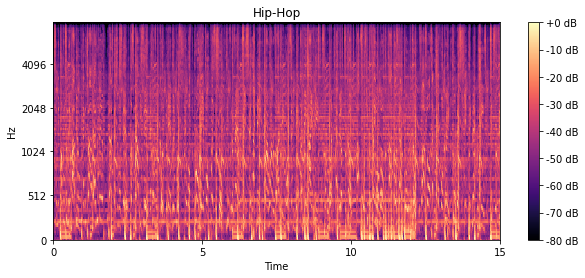

In [ ]:
plot_spectogram(2, 'Hip-Hop') # Create spectogram for track 2

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


660984 22050
(128, 646) Electronic


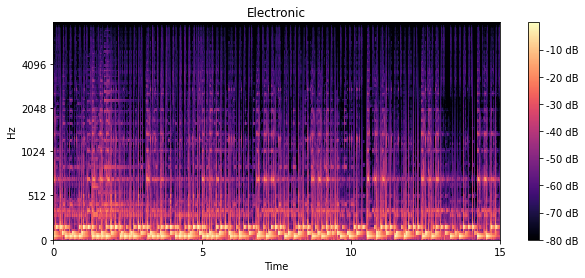

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


660984 22050
(128, 646) Experimental


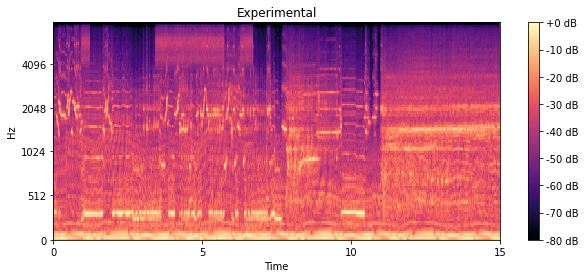

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


660984 22050
(128, 646) Folk


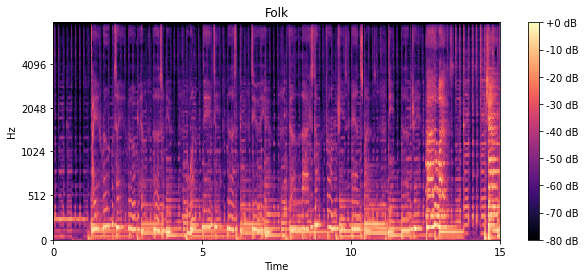

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


660984 22050
(128, 646) Hip-Hop


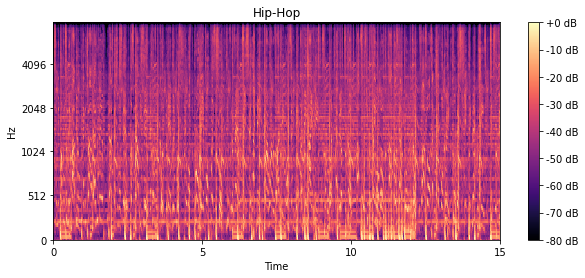

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


660984 22050
(128, 646) Instrumental


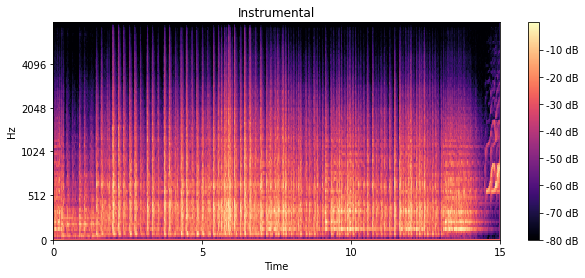

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


661560 22050
(128, 647) International


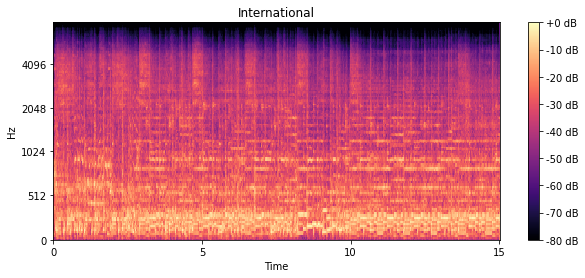

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


660984 22050
(128, 646) Pop


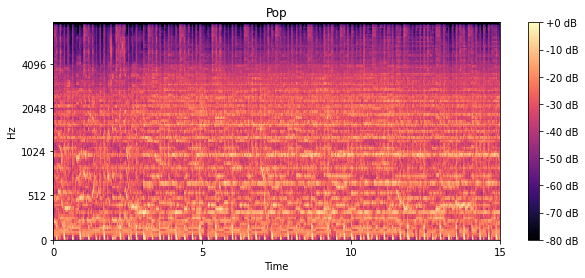

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


661560 22050
(128, 647) Rock


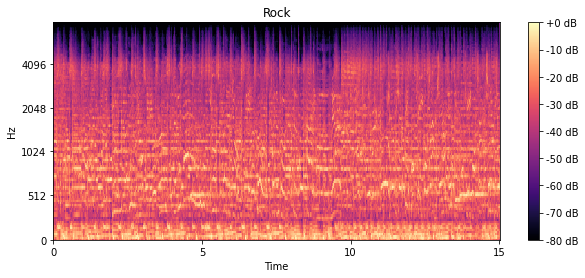

In [ ]:
# Visualize differences in spectrograms for each genre
for index, row in grouped_df.iterrows():
    track_id = int(row['track_id'])
    genre = row[('track', 'genre_top')]
    plot_spectogram(track_id, genre)

#### Spectrogram for all files (For LSTM model)

In [ ]:
'''
Read and convert file into melspecgtrogram, return as numpy array
'''
def read_convert_melspec(file_name,title = None):
  try:
    x,sr = librosa.load(file_name,sr = None)
  except:
    print(f"Can't read {file_name}")
    return None

  if title is None:
    title = file_name[:-4]
  spect = librosa.feature.melspectrogram(y=x, sr=sr,n_fft=2048, hop_length=1024)
  spect = librosa.power_to_db(spect, ref=np.max)
  return spect

In [ ]:
'''
Read and store all file path and store in a list
'''
def read_all_file():
  total_audio_list = []
  for i in range(156):
    if i < 10:
      string = "00"+str(i)
    elif i < 100:
      string = "0"+str(i)
    else :
      string = str(i)
    list_file = glob.glob(f"{root_path}/{string}/*.mp3")
    total_audio_list.extend(list_file)

In [ ]:
'''
Assign audio from all directory to each genre group, based on the csv file
'''
def assign_audio_to_genre(total_audio_list,top_genre):
  seperate_genre_dict = {}
  for i in top_genre:
    seperate_genre_dict[i] = []

  for i in total_audio_list:
    for j in seperate_genre_dict.keys():
      try:
        if tracks[('track', 'genre_top')][int(i[-10:-4].lstrip('0'))] == j:
          seperate_genre_dict[j].append(i)
          continue
      except Exception as e:
        print(f"Exception {e}and the string is {i}")
        break

In [ ]:
'''
preprocess data and store them into hdf5 file
'''
def write_genre_hdf(genre_list,genre_name):
  list_store = []
  for i in genre_list:
    converted = read_convert_melspec(i)
    if converted is None:
      continue
    temp = {"name":i,"mel_spec":converted}

    list_store.append(temp)

  file_name = "mel_spec/"+genre_name+".hdf5"

  h = h5py.File(file_name, 'w')
  group = h.create_group(genre_name)
  for item in list_store:

    group.create_dataset(item["name"].replace("/","-"),data = item["mel_spec"])
  h.close()

In [ ]:
genre_list = tracks['track']['genre_top']['small']
total_audio_list = read_all_file()
seperate_genre_dict = assign_audio_to_genre(total_audio_list,genre_list)

In [ ]:
'''
Convert all to json file, there will be a file for each music genre
'''
for keys,values in list(seperate_genre_dict.items):
    write_genre_hdf(values,keys)

In [ ]:
'''
Reading the data out,
return a list of dictionary, each dictionary contains the name and preprocessed data
'''
def read_hdf(file_path):
    return_dict = []
    with h5py.File(file_path, 'r') as hf:
        print(list(hf.keys()))
        dataset = hf[file_path[9:-5]]
        print(len(list(dataset.keys())))
        keys = list(dataset.keys())
        for i in keys:
            return_dict.append({
                "name":i.replace("-","/"),
                "data":dataset[i][:]
            })
        return return_dict

# Model Selection, Tuning and Evaluation

### Baseline (Classical ML)

This purpose of this section is to implement a variety of machine learning models, which are then used as a baseline for performance comparison with neural network based classifiers to follow.

In [ ]:
# List of classical machine learning model candidates for baseline comparison
classifiers = {

}

feature_sets = {
#    'echonest_audio': ('echonest', 'audio_features'),
#    'echonest_social': ('echonest', 'social_features'),
#    'echonest_temporal': ('echonest', 'temporal_features'),
#    'echonest_audio/social': ('echonest', ('audio_features', 'social_features')),
#    'echonest_all': ('echonest', ('audio_features', 'social_features', 'temporal_features')),
}

for name in features.columns.levels[0]:
    feature_sets[name] = name
    feature_sets.update({
        'mfcc/contrast': ['mfcc', 'spectral_contrast'],
        'mfcc/contrast/chroma': ['mfcc', 'spectral_contrast', 'chroma_cens'],
        'mfcc/contrast/centroid': ['mfcc', 'spectral_contrast', 'spectral_centroid'],
        'mfcc/contrast/chroma/centroid': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid'],
        'mfcc/contrast/chroma/centroid/tonnetz': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'tonnetz'],
        'mfcc/contrast/chroma/centroid/zcr': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'zcr'],
        'all_non-echonest': list(features.columns.levels[0])
    })



In [ ]:
features.columns.levels[0]

Index(['chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 'rmse',
       'spectral_bandwidth', 'spectral_centroid', 'spectral_contrast',
       'spectral_rolloff', 'tonnetz', 'zcr'],
      dtype='object', name='feature')

In [ ]:
features.columns.levels[1]

Index(['kurtosis', 'max', 'mean', 'median', 'min', 'skew', 'std'], dtype='object', name='statistics')

In [ ]:
# TODO: Uncomment only when required as this runs 10+ models and takes a while to execute.
scores, f1_scores = test_classifiers_features(classifiers, feature_sets)

# ipd.display(format_scores(scores))

# Interpretation: 
# For (first) table below, feature set (row) and model (column), it performed with x% accuracy
# so we can see (mfa + contrast + centroid) with model SVCrbf was the top performing combination, 
# with an accuracy of ~49.00% but the other combinations including all_non-echonest were similar at  47.88-49%
# so our conclusion is likely that one of the bottom 5 table results performed "well"
# with model SVCrbf (radial based kernel function) best overall

# TODO ignore second result table for now (with F1_score), it is incomplete

NameError: ignored

### Neural Networks

#### CNN

#### LSTM

#### Transfer Learning Approach

#### GRU

#### CRNN

In [ ]:
import os
import numpy as np
from os.path import isfile

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda

from keras import backend
from keras.layers import ELU
from keras import regularizers
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

import librosa
import librosa.display

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
%matplotlib inline

In [ ]:
genres_dict = {
    'Electronic': 0, 
    'Experimental': 1, 
    'Folk': 2, 
    'Hip-Hop': 3, 
    'Instrumental': 4,
    'International': 5, 
    'Pop': 6, 
    'Rock': 7  
}

reverse_genres_dic = {v: k for k, v in genres_dict.items()}

In [ ]:
npz_file = np.load('input/shuffled_train.npz')
# print(npz_file.files)
X_train = npz_file['arr_0'] # get array from the first file 
y_train = npz_file['arr_1'] # get array from the second file
print(X_train.shape, y_train.shape)

(6394, 640, 128) (6394, 8)


In [ ]:
npz_valid_file = np.load('input/shuffled_valid.npz')
# print(npz_valid_file.files)
X_valid = npz_valid_file['arr_0']
y_valid = npz_valid_file['arr_1']
print(X_valid.shape, y_valid.shape)

(800, 640, 128) (800, 8)


Experimental


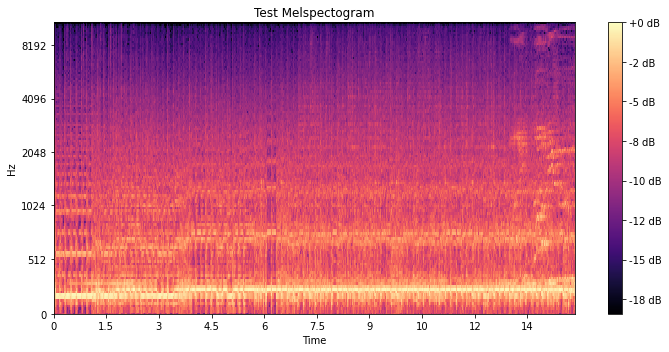

In [ ]:
# Check by plotting a Spectogram
num = 5300
spectogram = X_train[num]
genre_index = np.argmax(y_train[num])

print(reverse_genres_dic[genre_index])

plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

##### Implementation

In [ ]:
# Hyperparameters

batch_size = 32
num_classes = 8   # 8 genres classes in total
n_features = X_train.shape[2]
n_time = X_train.shape[1]
N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 32
LSTM_COUNT = 96
EPOCH_COUNT = 70
NUM_HIDDEN = 64
L2_regularization = 0.001

In [ ]:
def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### 3 1D Convolution Layers
    for i in range(N_LAYERS):
        # give name to the layers
        layer = Conv1D(
                filters=CONV_FILTER_COUNT,
                kernel_size=FILTER_LENGTH,
                kernel_regularizer=regularizers.l2(L2_regularization),  # Tried 0.001
                name='convolution_' + str(i + 1)
            )(layer)
        layer = BatchNormalization(momentum=0.9)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(0.4)(layer)
    
    ## LSTM Layer
    layer = LSTM(LSTM_COUNT, return_sequences=False)(layer)
    layer = Dropout(0.4)(layer)
    
    ## Dense Layer
    layer = Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_regularization), name='dense1')(layer)
    layer = Dropout(0.4)(layer)
    
    ## Softmax Output
    layer = Dense(num_classes)(layer)
    layer = Activation('softmax', name='output_realtime')(layer)
    model_output = layer
    model = Model(model_input, model_output)
    
    
    opt = Adam(learning_rate=0.001)
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())
    return model

In [ ]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_features = x_train.shape[2]
    input_shape = (None, n_features)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('./models/crnn/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history

In [ ]:
model, history  = train_model(X_train, y_train, X_valid, y_valid)

In [ ]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
show_summary_stats(history)

##### Evaluation

In [ ]:
y_true = np.argmax(y_valid, axis = 1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = genres_dict.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
print(accuracy_score(y_true, y_pred))

# Summary, Insights and Conclusions

TODO